# Importings:

In [1]:
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
import string
import os
import pandas as pd
from __future__ import division, print_function
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from scipy import spatial
from scipy.signal import argrelextrema
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.metrics.segmentation import pk
from nltk.metrics.segmentation import windowdiff
from time import time
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('uspto_desc.csv')

# Helper functions

In [8]:
stemmer = PorterStemmer()
# irrelevant characters specific for our dataset
noise = ['\'\'', ';', '..', '...',]

def is_digit(string):
    #Checks whether string is digit.
    return string.replace('.', '').replace('-', '').replace(',', '').isdigit()

def stem_tokens(tokens, stemmer):
    #Stemms tokens using Porter Stemmer.
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    #Tokenizes text.
    
    tokens = nltk.word_tokenize(text)
    tokens = list(map(lambda t: t.lower(), tokens))
    tokens = filter(lambda t: t not in string.punctuation, tokens)
    tokens = filter(lambda t: t not in ENGLISH_STOP_WORDS, tokens)
    tokens = filter(lambda t: not is_digit(t), tokens)
    tokens = filter(lambda t: t not in noise, tokens)
    tokens = filter(lambda t: t[0] != '\'', tokens)#remove strings like "'s" 
    stems = stem_tokens(tokens, stemmer)
    return stems

def doc_to_seg_string(n_sent, boundaries):
    #Creates string with binary values: 0 for segment and 1 for boundaries
    # this is used for evaluation
    
    seg_string = ''
    for i in range(n_sent):
        if i in boundaries:
            seg_string += '1'
        else:
            seg_string += '0'
    return seg_string

def print_top_words(model, feature_names, n_top_words):
    #return top words for each topic for LDA model.
    
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
def max_left(sequence, ind):
    # returns maximum value in sequence before index ind.
    
    max = sequence[ind]
    while (ind != 0) and (max <= sequence[ind-1]):
        max = sequence[ind-1]
        ind -= 1 
    return max

def max_right(sequence, ind):
    # returns maximum value in sequence after index ind.
    
    max = sequence[ind]
    while (ind != (len(sequence)-1)) and (max <= sequence[ind+1]):
        max = sequence[ind+1]
        ind+= 1  
    return max



     


## Create a class document for each description text to be read as a document

In [9]:
class Document:
    
    def __init__(self, row):
        
        self.row = row
        self.sentences = []
        self.boundaries = []
        self.segment_divider = "=========="
        
        self.load_document(row)
        
    def load_document(self, row):
        
        sentences = self.get_valid_sentences(row)
        for i, sentence in enumerate(sentences):
            if self.segment_divider not in sentence:
                self.sentences.append(sentence)
            else:
                self.boundaries.append(i - len(self.boundaries) - 1)
        #remove unecessary boundaries at beginning and the end
        del self.boundaries[0]
        del self.boundaries[-1]
        
    def get_valid_sentences(self, row):
        #filters sentences that are not valid like empty sentence
        sentences = []
        try:
            lines = row.split('\n')
            for line in lines:
                line = line.rstrip('\n')
                if tokenize(line):
                    # if line is valid
                    sentences.append(line)
        except:
            sentences = []
        
        return sentences
        
    
    def to_text(self):
        # creates an appendend string of sentences to represent the document
        
        return '\n'.join(self.sentences)
    
    def to_segments(self):
        
        # creates a list of segments based on boudaries to represent the document
        segments = []
        for i, boundary in enumerate(self.boundaries):
            if i == 0:
                segments.append(' '.join(self.sentences[0:boundary]))
            else:
                last_b = self.boundaries[i - 1]
                segments.append(' '.join(self.sentences[last_b:boundary]))
        segments.append(' '.join(self.sentences[self.boundaries[-1]:]))
        return segments

In [10]:
documents = []
indexes = []
for i in range(len(df)):
    try:
        documents = documents + [Document(df.loc[i,'description_text'])]
        indexes = indexes + [df.loc[i,'grant_id']]
    except:
        pass

In [11]:
class TopicTiling:
    """
    Implementation of Topic Tiling algorithm (M. Riedl and C. Biemann. 2012, Text Segmentation with Topic Models)
    
    :param m: Multiplier of standard deviation in condition for segmentation (c = mean - m*stddev).
    :param cosine_similarities: Cosine similarities between sentences.
    :param boundaries: Caluclated segments boundaries.

    """
    
    def __init__(self, m = 0.5):
        self.m = m
        self.cosine_similarities = None
        self.boundaries = None
        
    def fit(self, sentence_vectors):      
        
        #return: Calculates boundaries based on similatities between sentence vectors
        self.cosine_similarities = np.empty(0)
        depth_scores = []

        # calculating cosine similarities
        for i in range(0, len(sentence_vectors) - 1):
            sim = 1 - spatial.distance.cosine(sentence_vectors[i][0], sentence_vectors[i+1][0])
            self.cosine_similarities = np.append(self.cosine_similarities, sim)

        # get all local minima
        split_candidates_indices = argrelextrema(self.cosine_similarities, np.less_equal)[0]

        # calculating depth scores
        for i in split_candidates_indices:
            depth = 1/2 * (max_left(self.cosine_similarities, i) + max_right(self.cosine_similarities, i) - 2 * self.cosine_similarities[i])
            depth_scores.append((depth, i))

        tmp = np.array(list(map(lambda d: d[0], depth_scores)))
        
        # calculate segment threshold condition
        condition = tmp.mean() - self.m*tmp.std()
        
        # determine segment boundaries
        tmp = filter(lambda d: d[0] > condition, depth_scores)
        self.boundaries = [d[1] for d in tmp]
        
        return self.boundaries
    
    def set_m(self, m):
        """
        Setter for parameter m.
        """
        if m:
            self.m = m

# Segmentation Engine:
- Implementation of segmentation engine used for segmenting documents. Based on Latent Dirichlet Allocation model and Topic Tiling algorithm.

In [12]:
class SegmentationEngine(BaseEstimator):
    """
    
    
    :param vectorizer: CountVectorizer class used for transforming and cleaning input data.
    :param lda: Latent Dirichlet Allocation model.
    :param tt: Topic Tiling class.
    :param n_topics: Number of topics parameter of LDA.
    :param max_iter: Maximum number of iterations parameter of LDA.
    :param a: Document topics prior parameter of LDA.
    :param b: Topic document prior parameter of LDA.
    :param m: Multiplier parameter of Topic Tiling
    :param random_state: Random state.
    """
    
    def __init__(self, n_topics = 10, max_iter = None, a = None, b = None, m = None, random_state = None):
        """
        Initializes estimator.
        """
        self.n_topics = n_topics
        self.max_iter = max_iter
        self.a = a
        self.b = b
        self.m = m
        self.random_state = random_state
        
        self.vectorizer = CountVectorizer(max_df=0.95, min_df=2, tokenizer=tokenize, stop_words='english')
        self.lda = LatentDirichletAllocation( max_iter=max_iter, doc_topic_prior=a, topic_word_prior=b, random_state=random_state) #n_topics=n_topics,
        self.tt = TopicTiling(m=m)
        
    def fit(self, documents, input_type='segment'):
        """
        Trains segmentation engine.
        
        :param documents: List (iterable) of documents (class Document).
        :input_type: Determines basic input unit.Possible values are 'segment', 'document', 'sentence'. 
                     By default we use 'segment'.
        """
        t0 = time()
        
        train_data = self.parse_data(documents, input_type)
        X = self.vectorizer.fit_transform(train_data)
        self.lda.fit(X)
        
        print('Fitted in %0.2f seconds' % (time() - t0))
        
    def predict(self, documents):
        """
        Calculates segment boundaries for documents.
        
        :param documents: List (iterable) of documents (class Document).
        :return: List of boundaries for each document.
        """
        # TODO check if fit has been called
        estimated_boundaries = []
        for document in documents:
            sentence_vectors = [self.lda.transform(self.vectorizer.transform([sentence])) for sentence in document.sentences]
            estimated_boundaries.append(self.tt.fit(sentence_vectors))
        return estimated_boundaries
    

    def score(self, X, method = 'pk'):
        """
        Calculates segmentation score with Pk or WindowDiff measure.
        
        :param X: List (iterable) of documents (class Document).
        :param method: String which indicates which evaluation method should be used.
                       Possible evaluation methods are Pk measure ('pk') or WindowDiff method ('wd').
                       By default Pk measure is used.
        :return float: Evaluation score (actually method returns 1 - pk or 1 - wd because standard 
                       scikit learn grid search treats higher values as better while the oposite is 
                       the case with pk and wd).
        """
        if method == 'wd':
            scorer = windowdiff
        else:
            scorer = pk
            
        scores = np.empty(0)
        estimated_boundaries = self.predict(X)
        for i, document in enumerate(X):            
            ref_doc = doc_to_seg_string(len(document.sentences), document.boundaries)
            estimated_doc = doc_to_seg_string(len(document.sentences), estimated_boundaries[i])
            # calculate k
            try:
                k = int(round(len(ref_doc) / (ref_doc.count('1') * 2.)))
            except:
                k = int(round(len(ref_doc) / 2.))
            scores = np.append(scores, scorer(ref_doc, estimated_doc, k))
        return 1 - scores.mean()    
                
                
    def set_params(self, **params):
        """
        Sets value of parameters.
        
        :param params: Dictionary of parameters to be set.
        """
        super(SegmentationEngine, self).set_params(**params)

        # refresh parameters
        self.lda.set_params(n_components=self.n_topics, max_iter=self.max_iter, doc_topic_prior=self.a, topic_word_prior=self.b, random_state=self.random_state)
        self.tt.set_m(self.m)
        return self
        
    def parse_data(self, documents, input_type='segment'):
        """
        Transforms list of documents into list of segments.
        :param documents: List of documents (class Document)
        :input_type: Determines basic input unit.Possible values are 'segment', 'document', 'sentence'. 
                     By default we use 'segment'.
        :return list: List of segments.
        """
        train_data = []
        for document in documents:
            if input_type == 'segment':
                train_data.extend(document.to_segments())
            elif input_type == 'sentence':
                train_data.extend(document.sentences)
            elif input_type == 'document':
                train_data.append(document.to_text())
            else:
                raise ValueError('Invalid input_type parameter!')
        return train_data

# Prepare the segmentation engine

In [12]:
engine = SegmentationEngine(n_topics=100, max_iter=70, a=0.1, b=0.01, m=0.5)
splitter = ShuffleSplit(len(documents), test_size=.05, random_state=273) #, n_iter=1

X_train = []
X_test = []
for train_indices, test_indices in splitter.split(documents):
    X_train = [documents[i] for i in train_indices[:100] if documents[i].sentences != []] # take 100 documents
    X_test = [documents[i] for i in test_indices if documents[i].sentences != []]


# Fit the model

In [12]:
# Input: SEGMENT
print('SEGMENT')
engine.fit(X_train, input_type='segment')
print('Pk = %f' % (1 - engine.score(X_test)))
print('WD = %f' % (1 - engine.score(X_test, method='wd')))

# Input: DOCUMENT
print('DOCUMENT')
engine.fit(X_train, input_type='document')
print('Pk = %f' % (1 - engine.score(X_test)))
print('WD = %f' % (1 - engine.score(X_test, method='wd')))

# Input: SENTENCE
print('SENTENCE')
engine.fit(X_train, input_type='sentence')
print('Pk = %f' % (1 - engine.score(X_test)))
print('WD = %f' % (1 - engine.score(X_test, method='wd')))

SEGMENT
Fitted in 129.20 seconds


/tmp/ipykernel_1621736/1040886791.py:49: RuntimeWarning: Mean of empty slice.
  condition = tmp.mean() - self.m*tmp.std()
/home/smidab/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/smidab/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/smidab/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/smidab/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Pk = 0.625871
WD = 0.627709
DOCUMENT
Fitted in 15.17 seconds
Pk = 0.607263
WD = 0.609179
SENTENCE
Fitted in 80.64 seconds
Pk = 0.604333
WD = 0.606245


# Split data with 20% test data and 80% for training

In [13]:
X_train, X_test = train_test_split(documents, test_size = 0.2, random_state = 273)
X_train = [x for x in X_train if x.sentences != []]
X_test = [x for x in X_test if x.sentences != []]

In [93]:
engine = SegmentationEngine(n_topics=150, max_iter=50, a=0.1, b=0.01, m=0.1, random_state=100)
engine.fit(X_train)

Fitted in 276.85 seconds


In [94]:
print('Pk = %f' % (1 - engine.score(X_test, method='pk')))
print('WD = %f' % (1 - engine.score(X_test, method='wd')))

/tmp/ipykernel_1776905/1040886791.py:49: RuntimeWarning: Mean of empty slice.
  condition = tmp.mean() - self.m*tmp.std()


Pk = 0.557015
WD = 0.557428


# Test on a sample

In [ ]:
doc = X_test[100]
plot_indices = engine.predict([doc])[0]

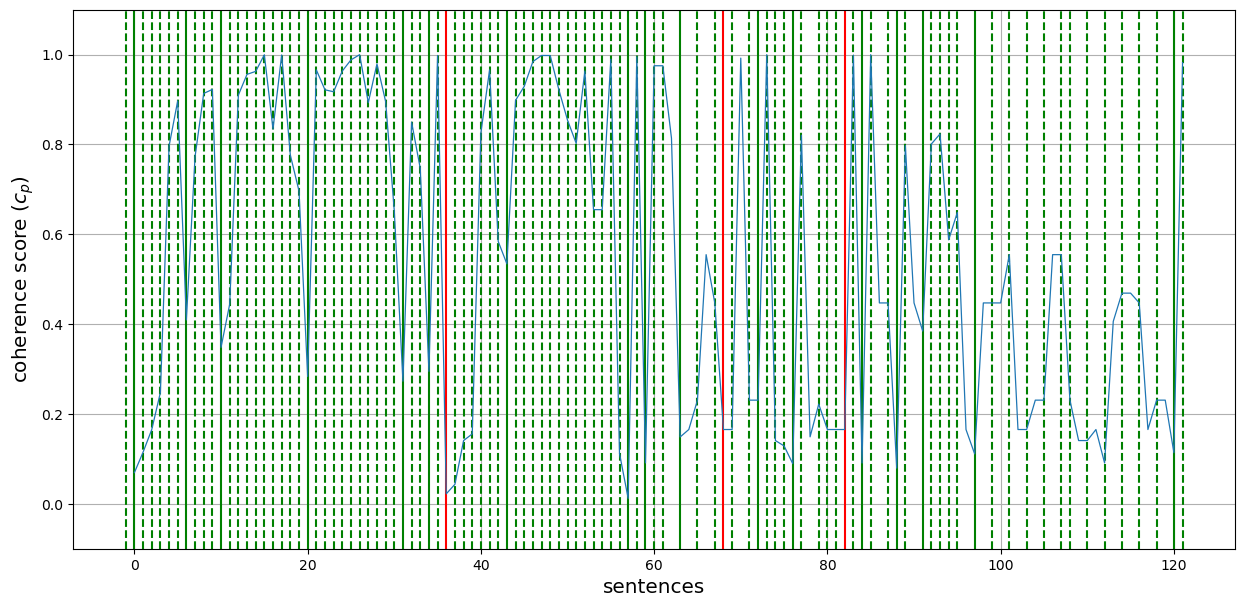

						   Pk 0.699187
						   WD 0.699187


In [96]:
tp = list(filter(lambda b: b in doc.boundaries, plot_indices))
fp = list(filter(lambda b: b not in doc.boundaries, plot_indices))
fn = list(filter(lambda b: b not in plot_indices, doc.boundaries))
tn = list(filter(lambda b: b not in doc.boundaries, plot_indices))

plt.figure(figsize=(15, 7))
plt.vlines(tp, -0.1, 1.1, 'g', linewidth=1.5)
plt.vlines(fp, -0.1, 1.1, 'r', linewidth=1.5)
plt.vlines(fn, -0.1, 1.1, 'g', linewidth=1.5, linestyles='dashed')
plt.plot(range(0, len(engine.tt.cosine_similarities)), engine.tt.cosine_similarities, linewidth=0.9)
plt.xlabel("sentences", fontsize='x-large')
plt.ylabel("coherence score ($c_p$)", fontsize='x-large')
plt.ylim(ymin = -0.1, ymax = 1.1)
plt.grid()
plt.show()

ref_doc = doc_to_seg_string(len(doc.sentences), doc.boundaries)
estimated_doc = doc_to_seg_string(len(doc.sentences), plot_indices)
k = int(round(len(ref_doc) / (ref_doc.count('1') * 2.)))

print('\t\t\t\t\t\t   Pk %f' % pk(ref_doc, estimated_doc))
print('\t\t\t\t\t\t   WD %f' % windowdiff(ref_doc, estimated_doc, k))

# Print evaluation metrics for the sample

In [99]:
precision = len(tp) / (len(tp)+len(fp)) 
recall = len(tp) / (len(tp)+len(fn))

In [ ]:
print('precision:', precision, 'recall:', recall, 'F1_score: ', 2*precision*recall/(precision+recall))